In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head(2)

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0


In [4]:
test_df.head(2)

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,117564,140.046875,54.507800,0.058862,-0.567263,2.337793,14.868335,9.591760,117.988781
1,117565,107.828125,51.578965,0.284368,-0.338430,1.574415,12.501437,11.694968,182.704822


In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [6]:
device

'cuda'

In [7]:
X_train_val = train_df.drop(["id", "Class"], axis=1).to_numpy()
X_test = test_df.drop(["id"], axis=1).to_numpy()

In [8]:
y_train_val = train_df.Class.to_numpy()

In [9]:
sc = StandardScaler()
X_train_val = sc.fit_transform(X_train_val)
X_test = sc.transform(X_test)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42)

In [ ]:
# from sklearn.neural_network import MLPClassifier
# sk_model = MLPClassifier(max_iter=1000)

# sk_model.fit(X_train, y_train)

# sk_pre_val = sk_model.predict(X_val)

# accuracy_score(y_val, sk_pre_val)

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train).to(device)
y_val = torch.tensor(y_val).to(device)

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

torch.Size([105807, 8]) torch.Size([105807])
torch.Size([11757, 8]) torch.Size([11757])
torch.Size([78377, 8])


In [13]:
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [14]:
model = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
loss_track = []

In [17]:
epochs = 1000
for i in range(epochs):

    # forward pass
    y_pred = model.forward(X_train)
    loss = loss_function(y_pred, y_train)

    # loss tracking
    loss_track.append(loss)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing things...
    if (i+1) % 100 == 0:
        print(f"epoch: {i}, loss={loss.item()}")

epoch: 99, loss=0.04265196993947029
epoch: 199, loss=0.03446148335933685
epoch: 299, loss=0.03221144154667854
epoch: 399, loss=0.031156247481703758
epoch: 499, loss=0.030457792803645134
epoch: 599, loss=0.02987789362668991
epoch: 699, loss=0.029343020170927048
epoch: 799, loss=0.028887039050459862
epoch: 899, loss=0.028393875807523727
epoch: 999, loss=0.027995912358164787


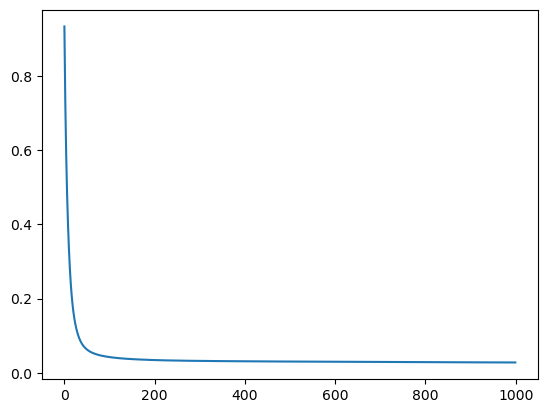

In [18]:
plt.plot([t.cpu().detach().numpy() for t in loss_track])

In [20]:
predicated_val_ans = torch.argmax(model(X_val), 1)
print(predicated_val_ans)
print(y_val)

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


In [21]:
val_accuracy = accuracy_score(y_val.cpu(), predicated_val_ans.cpu())
print("Validation accuracy is %.2f%%" % (val_accuracy*100))

Validation accuracy is 99.10%


In [22]:
predicated_test_ans = torch.argmax(model(X_test), 1)
print(predicated_test_ans)

tensor([0, 0, 0,  ..., 0, 0, 1], device='cuda:0')


In [23]:
ans_df = pd.DataFrame({"id": test_df.id, "Class": predicated_test_ans.cpu()})
ans_df.to_csv("outputs/ans14.csv", index=False)